Step 1 — Prepare Training Features

      For every image in your dataset:

      Count the number of white pixels for each lesion type (→ area_px).

      Divide by total image area → area_ratio (so it’s normalized).

      Optionally add derived features:

      Binary presence (1 if area > threshold, else 0)

      Relative ratios (e.g., HE/MA, SEx/HEx)

      Total lesion load (sum of all lesions)

      So for each image, your feature row will look like:

      ID	MA_px	HE_px	HEx_px	SEx_px	Disc_px	MA_ratio	HE_ratio	HEx_ratio	SEx_ratio	total_ratio	Stage
      25	8300	22000	4100	6700	600	0.015	0.041	0.008	0.013	0.077	3

      Stage labels come from the IDRiD “Image-level DR Grade” annotations (0–4).

⚗️ Step 2 — Model
      Random Forest Classifier

      Handles non-linear relations

      Works well on tabular features

      Gives feature importance scores

      Later, if you want to improve:

      Try XGBoost or a small MLP (Multilayer Perceptron).

___

DR Stage Classification (trainable + validated)

(0 = No DR, 1 = Mild, 2 = Moderate, 3 = Severe, 4 = Proliferative)

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# ✅ Load your trained segmentation model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DoubleConv(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_ch, out_ch, 3, padding=1),
            torch.nn.BatchNorm2d(out_ch),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_ch, out_ch, 3, padding=1),
            torch.nn.BatchNorm2d(out_ch),
            torch.nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(torch.nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)
        self.maxpool = torch.nn.MaxPool2d(2)
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)
        self.conv_last = torch.nn.Conv2d(64, n_classes, 1)
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        return out

# ----------------
# Load model weights
# ----------------
model = UNet(n_classes=5).to(device)
model.load_state_dict(torch.load(
    r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth",
    map_location=device
))
model.eval()

# ----------------
# Dataset paths
# ----------------
img_dir = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\B. Disease Grading\1. Original Images\a. Training Set"
output_csv = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\B. Disease Grading\lesion_features.csv"

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

lesion_names = ["MA_pixels", "HE_pixels", "EX_pixels", "SE_pixels", "OD_pixels"]
thresholds = [0.05, 0.06, 0.19, 0.07, 0.35]  # your calibrated values

records = []
for img_name in tqdm(os.listdir(img_dir)):
    if not img_name.lower().endswith((".jpg", ".png", ".tif")):
        continue
    img_path = os.path.join(img_dir, img_name)
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = torch.sigmoid(model(img_tensor)).cpu().numpy()[0]
    lesion_pixels = [int((pred[i] > thresholds[i]).sum()) for i in range(5)]
    records.append([img_name] + lesion_pixels)

# Save lesion features
df = pd.DataFrame(records, columns=["Image"] + lesion_names)
df.to_csv(output_csv, index=False)
print(f"✅ Lesion features saved at: {output_csv}")


C:\Users\HP\AppData\Local\Temp\ipykernel_19896\1951878944.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(
100%|██████████| 413/413 [05

✅ Lesion features saved at: C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\B. Disease Grading\lesion_features.csv


In [ ]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms

# Paths
base_dir = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\B. Disease Grading"
train_img_dir = os.path.join(base_dir, "1. Original Images", "a. Training Set")
gt_csv_path = os.path.join(base_dir, "2. Groundtruths", "a. IDRiD_Disease Grading_Training Labels.csv")

# Load trained segmentation model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_classes=5).to(device)
model.load_state_dict(torch.load(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth", map_location=device))
model.eval()

# Transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Otsu thresholds (from calibration)
thresholds = [0.05, 0.06, 0.19, 0.07, 0.35]
lesion_names = ["MA_pixels", "HE_pixels", "EX_pixels", "SE_pixels", "OD_pixels"]

records = []

for img_name in os.listdir(train_img_dir):
    if not img_name.lower().endswith((".jpg", ".png", ".tif")):
        continue

    img_path = os.path.join(train_img_dir, img_name)
    image = Image.open(img_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = torch.sigmoid(model(img_tensor)).cpu().numpy()[0]

    lesion_pixels = []
    for i in range(5):
        lesion_mask = (pred[i] > thresholds[i]).astype(np.uint8)
        lesion_pixels.append(float(np.sum(lesion_mask)))

    records.append([img_name] + lesion_pixels)

df_lesions = pd.DataFrame(records, columns=["Image"] + lesion_names)
print("✅ Extracted lesion features for", len(df_lesions), "images")

# Save intermediate file
df_lesions.to_csv("lesion_features_from_seg.csv", index=False)
print("💾 Saved lesion features → lesion_features_from_seg.csv")


C:\Users\HP\AppData\Local\Temp\ipykernel_19896\3792713240.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\HP\Desktop\gsfc\Se

✅ Extracted lesion features for 413 images
💾 Saved lesion features → lesion_features_from_seg.csv


In [ ]:
import pandas as pd

# Load lesion features and groundtruth
lesion_df = pd.read_csv("lesion_features_from_seg.csv")
gt_path = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\B. Disease Grading\2. Groundtruths\a. IDRiD_Disease Grading_Training Labels.csv"
gt_df = pd.read_csv(gt_path)

# Clean up column names
gt_df.columns = gt_df.columns.str.strip()

# 🩺 Normalize image names (remove file extensions, unify case)
lesion_df["Image_clean"] = lesion_df["Image"].str.replace(".jpg", "", regex=False).str.replace(".tif", "", regex=False).str.strip().str.lower()
gt_df["Image_clean"] = gt_df["Image name"].astype(str).str.strip().str.lower()

# Merge using the cleaned column
merged = pd.merge(lesion_df, gt_df, on="Image_clean", how="inner")

# Cleanup columns
merged.rename(columns={"Retinopathy grade": "Stage"}, inplace=True)
merged.drop(columns=["Image name", "Image_clean"], errors="ignore", inplace=True)

# Save merged dataset
print("✅ Merged dataset shape:", merged.shape)
merged.to_csv("dr_stage_training_data.csv", index=False)


✅ Merged dataset shape: (413, 17)


Train a Random Forest DR Stage Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load final merged dataset
df = pd.read_csv(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\dr_stage_training_data.csv")

X = df[["MA_pixels", "HE_pixels", "EX_pixels", "SE_pixels", "OD_pixels"]]
y = df["Stage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))
print("\n🌀 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



✅ Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.74      0.56        23
           1       1.00      0.14      0.25         7
           2       0.48      0.50      0.49        28
           3       0.22      0.12      0.16        16
           4       0.33      0.22      0.27         9

    accuracy                           0.43        83
   macro avg       0.50      0.35      0.35        83
weighted avg       0.45      0.43      0.40        83


🌀 Confusion Matrix:
 [[17  0  4  1  1]
 [ 4  1  1  0  1]
 [ 8  0 14  4  2]
 [ 8  0  6  2  0]
 [ 1  0  4  2  2]]


| Metric               | What it means                                              | How you're doing                                                                           |
| -------------------- | ---------------------------------------------------------- | ------------------------------------------------------------------------------------------ |
| **Accuracy: 0.43**   | About 43% of test images were correctly classified overall | Not bad for *pure lesion-pixel-based inference* (no fundus-level deep features)!           |
| **Precision**        | When the model says “Stage 2,” how often it’s right        | You’re best for **Stage 0 (No DR)** and **Stage 2 (Moderate)**                             |
| **Recall**           | How many actual Stage 2s you successfully caught           | You’re recalling well for **Stage 0 and 2**, not so much for **1, 3, 4**                   |
| **Confusion Matrix** | Shows *which stages get confused*                          | You can see overlap between 2↔3 and 3↔0 — makes sense, since lesions overlap in mid-stages |


In [ ]:
test_image_path = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\B. Disease Grading\1. Original Images\b. Testing Set\IDRiD_093.jpg"

image = Image.open(test_image_path).convert("RGB")
img_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    pred = torch.sigmoid(model(img_tensor)).cpu().numpy()[0]

lesion_pixels = [(pred[i] > thresholds[i]).sum() for i in range(5)]
feature_vector = np.array(lesion_pixels).reshape(1, -1)

predicted_stage = clf.predict(feature_vector)[0]
print(f"🩸 Predicted DR Stage for {os.path.basename(test_image_path)} → {predicted_stage}")


🩸 Predicted DR Stage for IDRiD_093.jpg → 2


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Load dataset

df = pd.read_csv(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\dr_stage_training_data.csv")

# Ensure numeric columns only
df = df.dropna(subset=["Stage"])
df["Stage"] = df["Stage"].astype(int)

X = df[["MA_pixels", "HE_pixels", "EX_pixels", "SE_pixels", "OD_pixels"]]
y = df["Stage"]

# -------------------------------
#  Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
#  Train RandomForest model

clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(X_train, y_train)

# -------------------------------
# Evaluate

y_pred = clf.predict(X_test)

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))
print("\n🌀 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# -------------------------------
#  Save model for later inference

joblib.dump(clf, "dr_stage_model.pkl")
print("✅ Model saved as dr_stage_model.pkl")



✅ Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.81      0.61        27
           1       0.00      0.00      0.00         4
           2       0.53      0.59      0.56        27
           3       0.00      0.00      0.00        15
           4       0.33      0.10      0.15        10

    accuracy                           0.47        83
   macro avg       0.27      0.30      0.27        83
weighted avg       0.37      0.47      0.40        83


🌀 Confusion Matrix:
 [[22  0  4  1  0]
 [ 3  0  0  1  0]
 [ 8  0 16  2  1]
 [ 7  0  7  0  1]
 [ 5  0  3  1  1]]
✅ Model saved as dr_stage_model.pkl


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

C:\Users\HP\AppData\Local\Temp\ipykernel_19896\1252658632.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model.load_state_dict(torch.load(


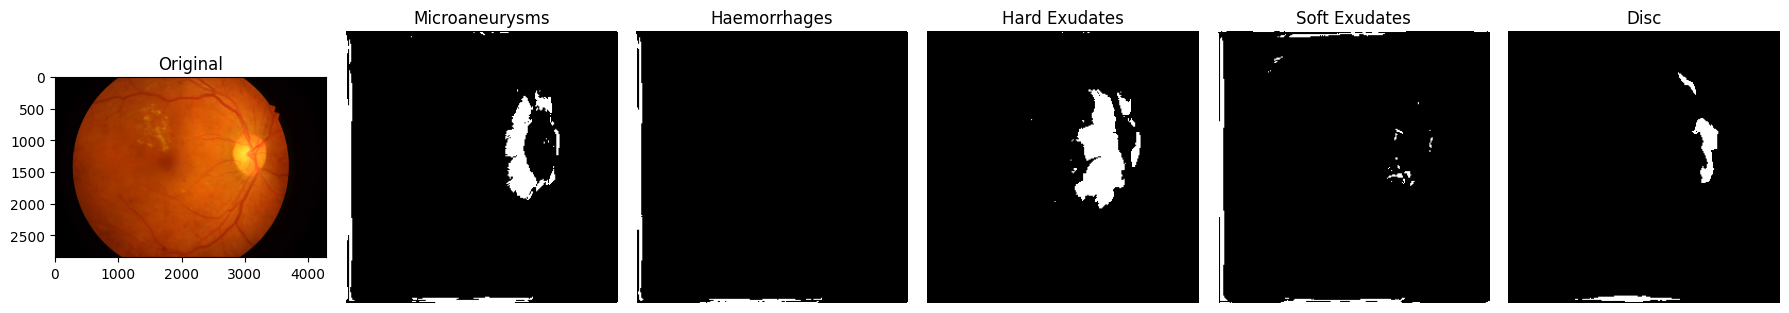


🩺 Results for C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\B. Disease Grading\1. Original Images\a. Training Set\IDRiD_059.jpg
Microaneurysms       | Pixels:   3541.0 | ✅ Present
Haemorrhages         | Pixels:   1407.0 | ✅ Present
Hard Exudates        | Pixels:   3439.0 | ✅ Present
Soft Exudates        | Pixels:   2062.0 | ✅ Present
Disc                 | Pixels:   1088.0 | ✅ Present

🎯 Predicted DR Stage: 2 (Moderate)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import joblib
import pandas as pd
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# -------------------------------
# Define UNet (same as before)

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)
        self.conv_last = nn.Conv2d(64, n_classes, 1)
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        return out

# -------------------------------
# Load models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_model = UNet(n_classes=5).to(device)
unet_model.load_state_dict(torch.load(
    r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth",
    map_location=device
))
unet_model.eval()

dr_stage_model = joblib.load(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\dr_stage_model.pkl")

# -------------------------------
#  Lesion Detection + DR Stage Prediction

def predict_dr_stage(image_path, thresholds=[0.05, 0.06, 0.19, 0.07, 0.35]):
    lesion_names = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = torch.sigmoid(unet_model(img_tensor)).cpu().numpy()[0]

    lesion_pixels = []
    results = []
    fig, axes = plt.subplots(1, len(lesion_names) + 1, figsize=(18, 6))
    axes[0].imshow(image)
    axes[0].set_title("Original")

    for i, lesion in enumerate(lesion_names):
        mask = (pred[i] > thresholds[i]).astype(np.uint8)
        lesion_pixels.append(mask.sum())
        present = "✅ Present" if mask.sum() > 100 else "❌ Absent"
        results.append((lesion, mask.sum(), present))
        axes[i + 1].imshow(mask, cmap="gray")
        axes[i + 1].set_title(lesion)
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

    lesion_pixels = np.array(lesion_pixels).reshape(1, -1)
    stage_pred = dr_stage_model.predict(lesion_pixels)[0]

    print(f"\n🩺 Results for {image_path}")
    for lesion, count, present in results:
        print(f"{lesion:20} | Pixels: {count:8.1f} | {present}")
    print(f"\n🎯 Predicted DR Stage: {stage_pred} ({['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'][stage_pred]})")


predict_dr_stage(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\B. Disease Grading\1. Original Images\a. Training Set\IDRiD_059.jpg")


C:\Users\HP\AppData\Local\Temp\ipykernel_19896\2625800021.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model.load_state_dict(torch.load(


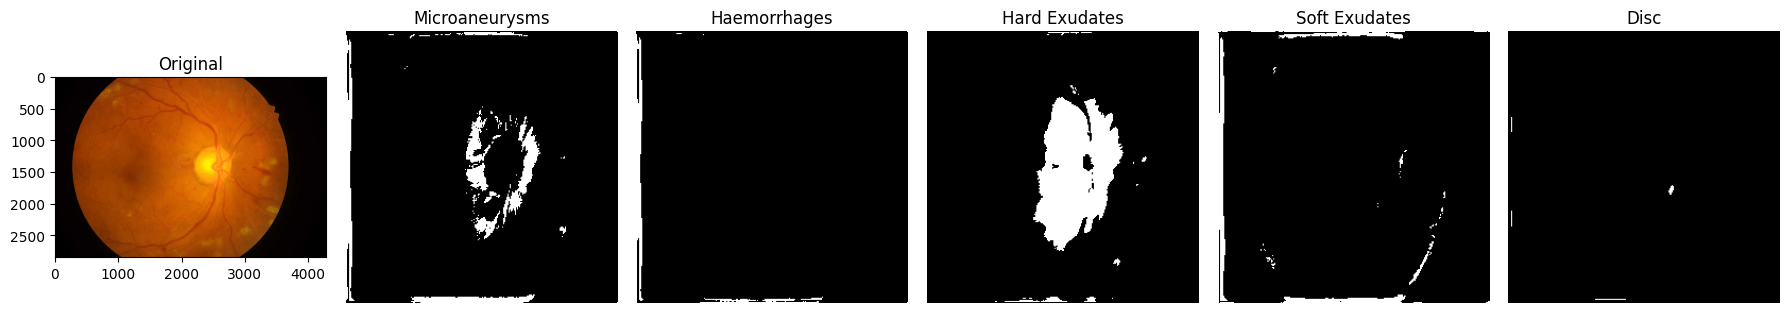


🩺 Results for C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\B. Disease Grading\1. Original Images\a. Training Set\IDRiD_010.jpg
Microaneurysms       | Pixels:   4061.0 | ✅ Present
Haemorrhages         | Pixels:   1395.0 | ✅ Present
Hard Exudates        | Pixels:   7896.0 | ✅ Present
Soft Exudates        | Pixels:   2569.0 | ✅ Present
Disc                 | Pixels:     85.0 | ❌ Absent

🎯 Predicted DR Stage: 4 (Proliferative)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import joblib
import pandas as pd
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# -------------------------------
# 1️⃣ Define UNet
# -------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)
        self.conv_last = nn.Conv2d(64, n_classes, 1)
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_model = UNet(n_classes=5).to(device)
unet_model.load_state_dict(torch.load(
    r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth",
    map_location=device
))
unet_model.eval()

dr_stage_model = joblib.load(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\dr_stage_model.pkl")


def predict_dr_stage(image_path, thresholds=[0.05, 0.06, 0.19, 0.07, 0.35]):
    lesion_names = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = torch.sigmoid(unet_model(img_tensor)).cpu().numpy()[0]

    lesion_pixels = []
    results = []
    fig, axes = plt.subplots(1, len(lesion_names) + 1, figsize=(18, 6))
    axes[0].imshow(image)
    axes[0].set_title("Original")

    for i, lesion in enumerate(lesion_names):
        mask = (pred[i] > thresholds[i]).astype(np.uint8)
        lesion_pixels.append(mask.sum())
        present = "✅ Present" if mask.sum() > 100 else "❌ Absent"
        results.append((lesion, mask.sum(), present))
        axes[i + 1].imshow(mask, cmap="gray")
        axes[i + 1].set_title(lesion)
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

    lesion_pixels = np.array(lesion_pixels).reshape(1, -1)
    stage_pred = dr_stage_model.predict(lesion_pixels)[0]

    print(f"\n🩺 Results for {image_path}")
    for lesion, count, present in results:
        print(f"{lesion:20} | Pixels: {count:8.1f} | {present}")
    print(f"\n🎯 Predicted DR Stage: {stage_pred} ({['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'][stage_pred]})")

# -------------------------------
#  Run on a sample image
# -------------------------------
predict_dr_stage(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\B. Disease Grading\1. Original Images\a. Training Set\IDRiD_010.jpg")


C:\Users\HP\AppData\Local\Temp\ipykernel_19896\817025982.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model.load_state_dict(torch.load(


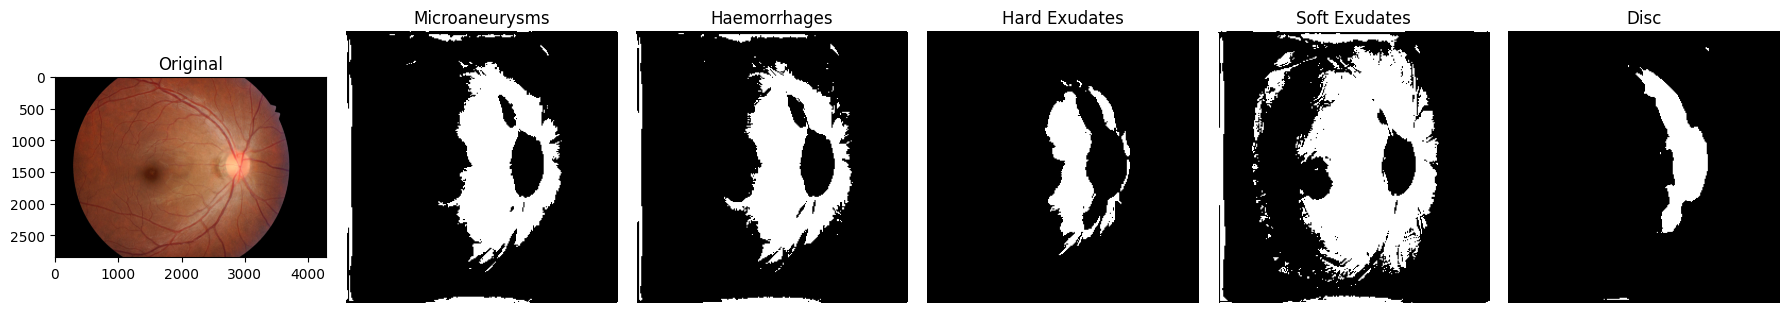


🩺 Results for C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\B. Disease Grading\1. Original Images\a. Training Set\IDRiD_212.jpg
Microaneurysms       | Pixels:  12584.0 | ✅ Present
Haemorrhages         | Pixels:  12544.0 | ✅ Present
Hard Exudates        | Pixels:   4890.0 | ✅ Present
Soft Exudates        | Pixels:  21541.0 | ✅ Present
Disc                 | Pixels:   3935.0 | ✅ Present

🎯 Predicted DR Stage: 0 (No DR)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import joblib
import pandas as pd
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# -------------------------------
# 1️⃣ Define UNet
# -------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)
        self.conv_last = nn.Conv2d(64, n_classes, 1)
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        return out

# -------------------------------
# 2️⃣ Load models
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_model = UNet(n_classes=5).to(device)
unet_model.load_state_dict(torch.load(
    r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth",
    map_location=device
))
unet_model.eval()

dr_stage_model = joblib.load(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\dr_stage_model.pkl")

# -------------------------------
# 3️⃣ Lesion Detection + DR Stage Prediction
# -------------------------------
def predict_dr_stage(image_path, thresholds=[0.05, 0.06, 0.19, 0.07, 0.35]):
    lesion_names = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = torch.sigmoid(unet_model(img_tensor)).cpu().numpy()[0]

    lesion_pixels = []
    results = []
    fig, axes = plt.subplots(1, len(lesion_names) + 1, figsize=(18, 6))
    axes[0].imshow(image)
    axes[0].set_title("Original")

    for i, lesion in enumerate(lesion_names):
        mask = (pred[i] > thresholds[i]).astype(np.uint8)
        lesion_pixels.append(mask.sum())
        present = "✅ Present" if mask.sum() > 100 else "❌ Absent"
        results.append((lesion, mask.sum(), present))
        axes[i + 1].imshow(mask, cmap="gray")
        axes[i + 1].set_title(lesion)
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

    lesion_pixels = np.array(lesion_pixels).reshape(1, -1)
    stage_pred = dr_stage_model.predict(lesion_pixels)[0]

    print(f"\n🩺 Results for {image_path}")
    for lesion, count, present in results:
        print(f"{lesion:20} | Pixels: {count:8.1f} | {present}")
    print(f"\n🎯 Predicted DR Stage: {stage_pred} ({['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'][stage_pred]})")

# -------------------------------
# 4️⃣ Run on a sample image
# -------------------------------
predict_dr_stage(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\B. Disease Grading\1. Original Images\a. Training Set\IDRiD_212.jpg")


C:\Users\HP\AppData\Local\Temp\ipykernel_19896\1991203177.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model.load_state_dict(torch.load(


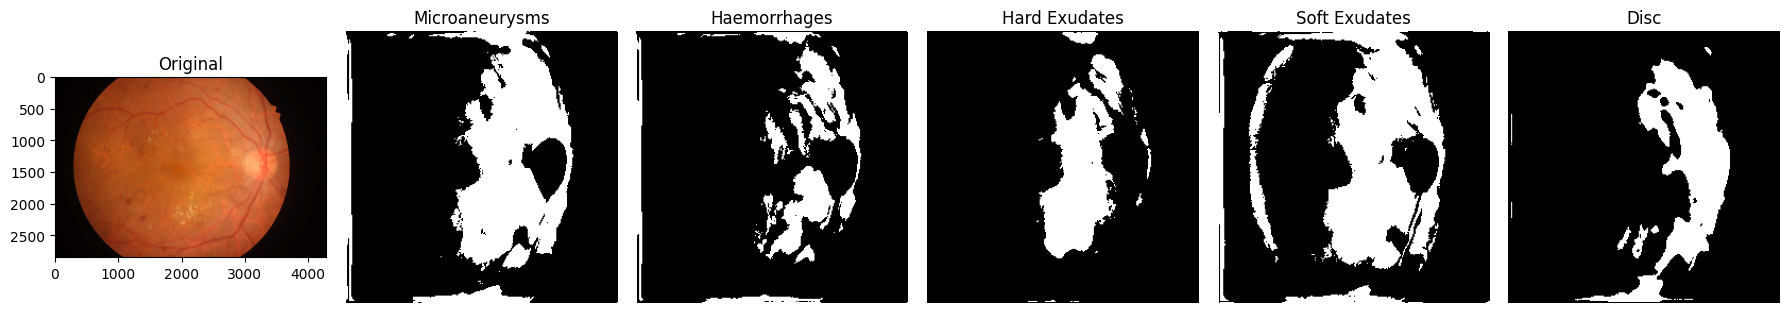


🩺 Results for C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\a. Training Set\IDRiD_01.jpg
Microaneurysms       | Pixels:  17505.0 | ✅ Present
Haemorrhages         | Pixels:   8689.0 | ✅ Present
Hard Exudates        | Pixels:   8484.0 | ✅ Present
Soft Exudates        | Pixels:  19761.0 | ✅ Present
Disc                 | Pixels:   9588.0 | ✅ Present

🎯 Predicted DR Stage: 0 (No DR)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import joblib
import pandas as pd
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# -------------------------------
# 1️⃣ Define UNet (same as before)
# -------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)
        self.conv_last = nn.Conv2d(64, n_classes, 1)
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        return out

# -------------------------------
# 2️⃣ Load models
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_model = UNet(n_classes=5).to(device)
unet_model.load_state_dict(torch.load(
    r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth",
    map_location=device
))
unet_model.eval()

dr_stage_model = joblib.load(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\dr_stage_model.pkl")

# -------------------------------
# 3️⃣ Lesion Detection + DR Stage Prediction
# -------------------------------
def predict_dr_stage(image_path, thresholds=[0.05, 0.06, 0.19, 0.07, 0.35]):
    lesion_names = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = torch.sigmoid(unet_model(img_tensor)).cpu().numpy()[0]

    lesion_pixels = []
    results = []
    fig, axes = plt.subplots(1, len(lesion_names) + 1, figsize=(18, 6))
    axes[0].imshow(image)
    axes[0].set_title("Original")

    for i, lesion in enumerate(lesion_names):
        mask = (pred[i] > thresholds[i]).astype(np.uint8)
        lesion_pixels.append(mask.sum())
        present = "✅ Present" if mask.sum() > 100 else "❌ Absent"
        results.append((lesion, mask.sum(), present))
        axes[i + 1].imshow(mask, cmap="gray")
        axes[i + 1].set_title(lesion)
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

    lesion_pixels = np.array(lesion_pixels).reshape(1, -1)
    stage_pred = dr_stage_model.predict(lesion_pixels)[0]

    print(f"\n🩺 Results for {image_path}")
    for lesion, count, present in results:
        print(f"{lesion:20} | Pixels: {count:8.1f} | {present}")
    print(f"\n🎯 Predicted DR Stage: {stage_pred} ({['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'][stage_pred]})")

# -------------------------------
# 4️⃣ Run on a sample image
# -------------------------------
predict_dr_stage(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\A. Segmentation\1. Original Images\a. Training Set\IDRiD_01.jpg")


C:\Users\HP\AppData\Local\Temp\ipykernel_19896\3811047761.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model.load_state_dict(torch.load(r"C:\Users\HP\Desktop\gs

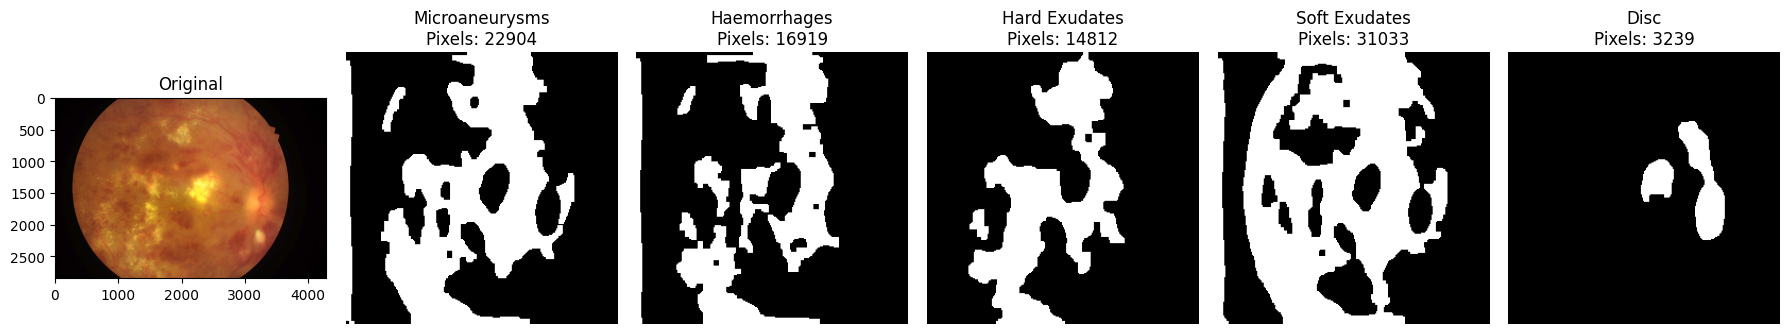

🎯 Predicted DR Stage: 4 (Proliferative)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import joblib

# ------------------------------
# Load both models
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load UNet for lesion segmentation
unet_model = UNet(n_classes=5).to(device)
unet_model.load_state_dict(torch.load(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth", map_location=device))
unet_model.eval()

# Load DR stage model
dr_model = joblib.load(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\dr_stage_model.pkl")

# ------------------------------
# Helper: clean mask
# ------------------------------
def clean_mask(mask, kernel_size=5, min_area=200):
    mask = mask.astype(np.uint8)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    cleaned = np.zeros_like(mask)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            cleaned[labels == i] = 1
    return cleaned

# ------------------------------
# Load test internet image
# ------------------------------
img_path = r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\C. Localization\1. Original Images\a. Training Set\IDRiD_022.jpg"
sample_image = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img_tensor = transform(sample_image).unsqueeze(0).to(device)

# ------------------------------
# Generate predictions
# ------------------------------
with torch.no_grad():
    pred = torch.sigmoid(unet_model(img_tensor)).cpu().numpy()[0]

lesion_names = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]
thresholds = [0.05, 0.06, 0.19, 0.07, 0.35]

pixel_counts = []
fig, axes = plt.subplots(1, len(lesion_names) + 1, figsize=(18, 6))
axes[0].imshow(sample_image)
axes[0].set_title("Original")

for i, lesion in enumerate(lesion_names):
    raw_mask = (pred[i] > thresholds[i]).astype(np.uint8)
    cleaned_mask = clean_mask(raw_mask)
    pixel_count = np.sum(cleaned_mask)
    pixel_counts.append(pixel_count)
    axes[i+1].imshow(cleaned_mask, cmap="gray")
    axes[i+1].set_title(f"{lesion}\nPixels: {pixel_count}")
    axes[i+1].axis("off")

plt.tight_layout()
plt.show()

# ------------------------------
# Predict DR Stage
# ------------------------------
X_input = np.array(pixel_counts).reshape(1, -1)
stage_pred = dr_model.predict(X_input)[0]
stage_names = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative"
}

print(f"🎯 Predicted DR Stage: {stage_pred} ({stage_names[stage_pred]})")


C:\Users\HP\AppData\Local\Temp\ipykernel_19896\2110724881.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model.load_state_dict(torch.load(


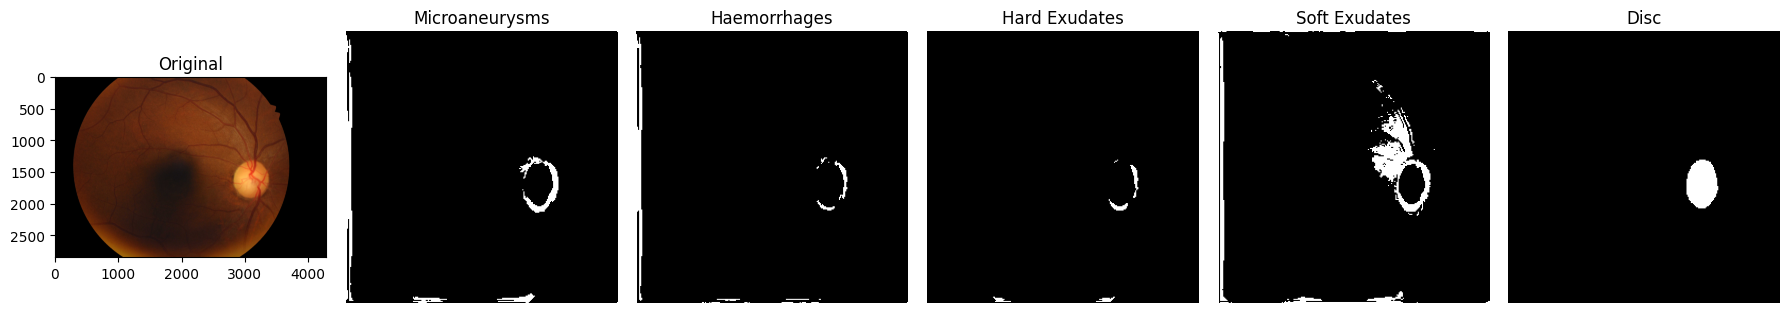


🩺 Results for C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\C. Localization/1. Original Images/a. Training Set/IDRiD_223.jpg
Microaneurysms       | Pixels:   1755.0 | ✅ Present
Haemorrhages         | Pixels:   1275.0 | ✅ Present
Hard Exudates        | Pixels:    260.0 | ✅ Present
Soft Exudates        | Pixels:   3490.0 | ✅ Present
Disc                 | Pixels:   1072.0 | ✅ Present

🎯 Predicted DR Stage: 0 (No DR)


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import joblib
import pandas as pd
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# -------------------------------
# 1️⃣ Define UNet (same as before)
# -------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)
        self.conv_last = nn.Conv2d(64, n_classes, 1)
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        return out

# -------------------------------
# 2️⃣ Load models
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_model = UNet(n_classes=5).to(device)
unet_model.load_state_dict(torch.load(
    r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\itworksunet.pth",
    map_location=device
))
unet_model.eval()

dr_stage_model = joblib.load(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\dr_stage_model.pkl")

# -------------------------------
# 3️⃣ Lesion Detection + DR Stage Prediction
# -------------------------------
def predict_dr_stage(image_path, thresholds=[0.05, 0.06, 0.19, 0.07, 0.35]):
    lesion_names = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Disc"]

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = torch.sigmoid(unet_model(img_tensor)).cpu().numpy()[0]

    lesion_pixels = []
    results = []
    fig, axes = plt.subplots(1, len(lesion_names) + 1, figsize=(18, 6))
    axes[0].imshow(image)
    axes[0].set_title("Original")

    for i, lesion in enumerate(lesion_names):
        mask = (pred[i] > thresholds[i]).astype(np.uint8)
        lesion_pixels.append(mask.sum())
        present = "✅ Present" if mask.sum() > 100 else "❌ Absent"
        results.append((lesion, mask.sum(), present))
        axes[i + 1].imshow(mask, cmap="gray")
        axes[i + 1].set_title(lesion)
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

    lesion_pixels = np.array(lesion_pixels).reshape(1, -1)
    stage_pred = dr_stage_model.predict(lesion_pixels)[0]

    print(f"\n🩺 Results for {image_path}")
    for lesion, count, present in results:
        print(f"{lesion:20} | Pixels: {count:8.1f} | {present}")
    print(f"\n🎯 Predicted DR Stage: {stage_pred} ({['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'][stage_pred]})")

# -------------------------------
# 4️⃣ Run on a sample image
# -------------------------------
predict_dr_stage(r"C:\Users\HP\Desktop\gsfc\Sem7\MPII\implementation_trial\second\C. Localization/1. Original Images/a. Training Set/IDRiD_223.jpg")


we first calculate the pixel counts of each lesion type (like microaneurysms, haemorrhages, hard and soft exudates, and optic disc) for every retinal image and save them in a CSV — this becomes our feature dataset.

Then we take the ground-truth DR stages from the official IDRiD grading CSV and merge both files using the image name. This gives us one combined dataset where each row contains lesion pixel counts (inputs) and the corresponding DR stage (label).

We train a Random Forest model on this merged data so it learns the relationship between lesion severity and disease stage.

Later, when a new image is given, the UNet model predicts lesion masks, we calculate their pixel counts, and feed those numbers to the trained Random Forest model — which finally predicts the DR stage for that image.